### 🎯 What You've Learned:

#### 1. The 8-Step Process:
- **Data Exploration** – Understand your data types and target  
- **Missing Values** – Handle them strategically (not just drop!)  
- **Feature Creation** – Make new meaningful features  
- **Categorical Encoding** – Choose the right encoding method  
- **Feature Scaling** – Standardize numerical features  
- **Feature Selection** – Remove redundant/irrelevant features  
- **Validation** – Test feature importance  
- **Pipeline Creation** – Make it reusable  

#### 2. Key Feature Engineering Techniques:  
_For Your Podcast Data:_

- ✅ Ratio Features: `completion_rate = listening_time / episode_length`  
- ✅ Aggregation Features: Podcast-level averages  
- ✅ Boolean Features: `is_weekend`, `has_guest`  
- ✅ Interaction Features: Combined popularity scores  
- ✅ Time Features: Weekend vs weekday patterns  
- ✅ Text Extraction: Episode numbers from titles  

#### 3. Encoding Strategies:

- **Ordinal Encoding:** For ordered categories (Negative < Neutral < Positive)  
- **One-Hot Encoding:** For nominal categories with few values (Genre)  
- **Target Encoding:** For high-cardinality categories (Podcast_Name)  

#### 4. Missing Value Strategies:

- Domain-specific filling: Episode length by genre median  
- Create indicators: `Has_Guest` feature  
- Meaningful defaults: Guest popularity = 0 for solo episodes  


In [1]:
!nvidia-smi

Wed Jul  9 15:30:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.51                 Driver Version: 555.97         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0             24W /   81W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%load_ext cuml.accel

cuML: Accelerator installed.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import tensorflow as tf
#import tensorflow_decision_forests as tfdf
from math import ceil, sqrt
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

2025-07-09 15:30:31.412109: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 15:30:31.521314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752093031.544033    3253 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752093031.552427    3253 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 15:30:31.681017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
# Set GPU device in notebook
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use first GPU

# For TensorFlow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Step 1: **Understand Your Data**

**What you do here:**

* Check how many rows and columns your dataset has.
* Identify the **target variable** — the one you want to predict. Here, it’s `Listening_Time_minutes`.
* Determine which features are numerical (numbers like episode length, percentages) and which are categorical (like podcast genre or name).
* Look for missing values (nulls) and get a sense of which columns have them.
* Ask important questions about your data:

  * What do features mean?
  * Which might influence your target?
  * Are there any oddities or patterns?

**Why this matters:**
You can’t engineer good features without knowing your data. This step sets the foundation and guides all later decisions.

In [5]:
df = pd.read_csv('train.csv',index_col = 'id' )
df_test  = pd.read_csv('test.csv', index_col = 'id' )
df_sub = pd.read_csv('sample_submission.csv')

In [6]:
print("Full train dataset shape is {}".format(df.shape))
print("Full train dataset shape is {}".format(df_test.shape))

Full train dataset shape is (750000, 11)
Full train dataset shape is (250000, 10)


In [7]:
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  object 
 1   Episode_Title                750000 non-null  object 
 2   Episode_Length_minutes       662907 non-null  float64
 3   Genre                        750000 non-null  object 
 4   Host_Popularity_percentage   750000 non-null  float64
 5   Publication_Day              750000 non-null  object 
 6   Publication_Time             750000 non-null  object 
 7   Guest_Popularity_percentage  603970 non-null  float64
 8   Number_of_Ads                749999 non-null  float64
 9   Episode_Sentiment            750000 non-null  object 
 10  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), object(6)
memory usage: 68.7+ MB


In [9]:
# Check missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64


In [10]:
df.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,64.504738,59.859901,52.236449,1.348855,45.437406
std,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.730000,39.410000,28.380000,0.000000,23.178350
50%,63.840000,60.050000,53.580000,1.000000,43.379460
75%,94.070000,79.530000,76.600000,2.000000,64.811580
max,325.240000,119.460000,119.910000,103.910000,119.970000


In [11]:
# Strategy 1: Episode_Length_minutes (9.5% missing)
# Fill with median by genre (different genres might have different typical lengths)
df['Episode_Length_minutes'] = df.groupby('Genre')['Episode_Length_minutes'].transform(
    lambda x: x.fillna(x.median())
)

In [12]:
# Strategy 2: Guest_Popularity_percentage (20.1% missing)
# Create a binary feature indicating if guest info is available
df['Has_Guest'] = df['Guest_Popularity_percentage'].notna().astype(int)

# This creates a new boolean column Has_Guest.
# For each row, if Guest_Popularity_percentage is not missing (not NaN), it sets True.
# If Guest_Popularity_percentage is missing (NaN), it sets False.
# So it's not filling missing values here; rather, it flags whether the original value exists or not.

In [13]:
# Fill missing guest popularity with 0 (no guest)
df['Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].fillna(0)

print("✅ Missing values handled!")

# This creates a new column Guest_Popularity_filled.
# It replaces all missing values (NaN) in Guest_Popularity_percentage with 0.
# This is useful if you want to use this feature as a numeric input in models where missing values are not allowed.

✅ Missing values handled!


In [14]:
# Simple - use median or mode
df['Number_of_Ads'] = df['Number_of_Ads'].fillna(df['Number_of_Ads'].median())

In [15]:
# Always check if your imputation makes sense:
# 1. Does the distribution look reasonable?
# 2. Do relationships between variables still hold?
# 3. Does it reflect real-world behavior?

# Example validation:
print("Average episode length by genre after imputation:")
print(df.groupby('Genre')['Episode_Length_minutes'].mean())

Average episode length by genre after imputation:
Genre
Business      64.493233
Comedy        63.151190
Education     64.865062
Health        65.254039
Lifestyle     64.793281
Music         65.938848
News          63.644954
Sports        64.244717
Technology    63.876697
True Crime    64.454171
Name: Episode_Length_minutes, dtype: float64


# 💡 Why These Strategies?

1. **Genre-based median**: Different podcast genres likely have different typical lengths
2. **Has_Guest feature**: The fact that guest info is missing might be meaningful (solo episodes)
3. **Fill with 0**: Makes sense if no guest means no guest popularity

### Step 3: **Create New Features**

Feature creation transforms existing data into more useful representations that can better explain patterns in your target.

---

#### 3.1 Extract Info from Text (`Episode_Title`)

* Pull out the **episode number** from the episode title text using regex (e.g., “Episode 23” → 23).
* Create bins like “Early,” “Mid,” and “Late” episodes to capture progression or maturity effects.

In [16]:
# Extract episode number
df['Episode_Number'] = df['Episode_Title'].str.extract('(\d+)').astype(float)

# Create episode number bins (early, mid, late episodes)
df['Episode_Stage'] = pd.cut(df['Episode_Number'], 
                           bins=[0, 10, 50, 200], 
                           labels=['Early', 'Mid', 'Late'])

---

#### 3.2 Create Ratios and Interaction Features

* **Completion Rate:** How much of the episode was listened to (listening time divided by episode length), capped at 100%.
* **Host-Guest Popularity Ratio:** How popular is the host relative to the guest? Might affect listener interest.
* **Ad Density:** Number of ads per minute of episode length — might affect listener drop-off.
* **Total Popularity:** Combined host and guest popularity — an overall popularity measure.

---

In [17]:
df['Host_Popularity_percentage'].describe()
df['Number_of_Ads'].describe()
df['Guest_Popularity_percentage'].describe()
df['Episode_Length_minutes'].describe()

count    750000.000000
mean         64.422139
std          30.998877
min           0.000000
25%          39.420000
50%          63.910000
75%          90.310000
max         325.240000
Name: Episode_Length_minutes, dtype: float64

In [18]:
count_ads_over_50 = (df['Episode_Length_minutes'] > 200).sum()
print(f"Number of episodes with more than 50 ads: {count_ads_over_50}")
df[df['Episode_Length_minutes'] > 121]

Number of episodes with more than 50 ads: 1


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Has_Guest,Episode_Number,Episode_Stage
id,,,,,,,,,,,,,,
101637,Home & Living,Episode 16,325.24,Lifestyle,50.69,Tuesday,Afternoon,15.01,0.0,Positive,64.31981,1,16.0,Mid


In [23]:
import pandas as pd

# Calculate counts for Episode_Length_minutes thresholds
count_over_100 = (df['Episode_Length_minutes'] > 100).sum()
count_over_150 = (df['Episode_Length_minutes'] > 150).sum()
count_over_200 = (df['Episode_Length_minutes'] > 200).sum()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Threshold': ['> 100', '> 150', '> 200'],
    'Count': [count_over_100, count_over_150, count_over_200]
})

print(summary_df)



  Threshold   Count
0     > 100  127196
1     > 150       1
2     > 200       1


In [24]:
import numpy as np

upper_limit = df['Number_of_Ads'].quantile(0.95)
df['Number_of_Ads_Capped'] = np.where(df['Number_of_Ads'] > upper_limit, upper_limit, df['Number_of_Ads'])


In [25]:
df['Host_Popularity_percentage'] = df['Host_Popularity_percentage'].clip(upper=100)

In [26]:
df['Number_of_Ads'] = df['Number_of_Ads'].clip(upper=3)

In [27]:
df['Episode_Length_minutes'] = df['Host_Popularity_percentage'].clip(upper=120)

In [28]:
df['Guest_Popularity_percentage'] = df['Host_Popularity_percentage'].clip(upper=100)

In [29]:
count_ads_over_50 = (df['Host_Popularity_percentage'] > 100).sum()
print(f"Number of episodes with more than 50 ads: {count_ads_over_50}")
df[df['Host_Popularity_percentage'] > 100]


Number of episodes with more than 50 ads: 0


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Has_Guest,Episode_Number,Episode_Stage,Number_of_Ads_Capped
id,,,,,,,,,,,,,,,


---
#### 3.3 Time-Based Features

* Flag if episode was published on a **weekend** — listening behavior can differ on weekends.
* Flag **time of day** (morning, evening, night) for publication — time might influence listening habits.
* Combine day and time flags for interactions like “weekend evening.”
---

In [16]:
# Create day type features
weekend_days = ['Saturday', 'Sunday']
df['Is_Weekend'] = df['Publication_Day'].isin(weekend_days).astype(int)

# Create time of day features
morning_times = ['Morning']
evening_times = ['Evening', 'Night']
df['Is_Morning'] = df['Publication_Time'].isin(morning_times).astype(int)
df['Is_Evening'] = df['Publication_Time'].isin(evening_times).astype(int)

# Combine day and time
df['Weekend_Evening'] = (df['Is_Weekend'] & df['Is_Evening']).astype(int)

In [17]:
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,...,Episode_Number,Episode_Stage,Completion_Rate,Host_Guest_Popularity_Ratio,Ad_Density,Total_Popularity,Is_Weekend,Is_Morning,Is_Evening,Weekend_Evening
id,,,,,,,,,,,,,,,,,,,,,
0,Mystery Matters,Episode 98,63.80,True Crime,74.81,Thursday,Night,0.00,0.0,Positive,...,98.0,Late,0.492476,74.810000,0.000000,74.81,0,0,1,0
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,...,26.0,Mid,0.734661,0.870045,0.016694,142.90,1,0,0,0
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,...,16.0,Mid,0.607920,7.018054,0.000000,78.94,0,0,1,0
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,...,45.0,Mid,0.688972,0.717942,0.029775,135.92,0,1,0,0
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,...,86.0,Late,0.684194,1.341655,0.027147,138.75,0,0,0,0



---

#### 3.4 Categorical Aggregation Features

* Calculate podcast-level stats like average listening time, average host popularity, and episode count.
* Merge these back as features, giving context about the podcast’s general popularity or activity.
---


### Imagine you have a DataFrame `df` like this:

| Podcast\_Name | Listening\_Time\_minutes | Host\_Popularity\_percentage | Episode\_Length\_minutes |
| ------------- | ------------------------ | ---------------------------- | ------------------------ |
| TechTalk      | 30                       | 75                           | 40                       |
| TechTalk      | 45                       | 75                           | 40                       |
| DailyNews     | 20                       | 60                           | 25                       |
| DailyNews     | 22                       | 60                           | 30                       |
| DailyNews     | 18                       | 60                           | 25                       |

---

### Step 1: Group and calculate statistics

```python
podcast_stats = df.groupby('Podcast_Name').agg({
    'Listening_Time_minutes': ['mean', 'std', 'count'],
    'Host_Popularity_percentage': 'mean',
    'Episode_Length_minutes': 'mean'
}).round(2)
```

This groups rows by `'Podcast_Name'` and calculates:

* Mean, standard deviation, and count of `Listening_Time_minutes`
* Mean of `Host_Popularity_percentage`
* Mean of `Episode_Length_minutes`

**Result:**

| Podcast\_Name | Listening\_Time\_minutes\_mean | Listening\_Time\_minutes\_std | Listening\_Time\_minutes\_count | Host\_Popularity\_percentage\_mean | Episode\_Length\_minutes\_mean |
| ------------- | ------------------------------ | ----------------------------- | ------------------------------- | ---------------------------------- | ------------------------------ |
| DailyNews     | 20.00                          | 2.00                          | 3                               | 60.00                              | 26.67                          |
| TechTalk      | 37.50                          | 10.61                         | 2                               | 75.00                              | 40.00                          |

---

### Step 2: Flatten column names

Because `.agg()` with multiple functions creates multi-level column names, the code flattens it:

```python
podcast_stats.columns = ['_'.join(col).strip() for col in podcast_stats.columns]
```

**Resulting columns:**

* `Listening_Time_minutes_mean`
* `Listening_Time_minutes_std`
* `Listening_Time_minutes_count`
* `Host_Popularity_percentage_mean`
* `Episode_Length_minutes_mean`

---

### Step 3: Merge stats back to the original dataframe

```python
df = df.merge(podcast_stats, left_on='Podcast_Name', right_index=True, how='left')
```

Each row in the original dataframe gets the aggregated podcast-level stats added as new columns. For example, the first row with `Podcast_Name` = "TechTalk" now has:

* `Listening_Time_minutes_mean`: 37.5
* `Listening_Time_minutes_std`: 10.61
* `Listening_Time_minutes_count`: 2
* `Host_Popularity_percentage_mean`: 75
* `Episode_Length_minutes_mean`: 40

---

### Step 4: Rename columns for clarity

```python
df.rename(columns={
    'Listening_Time_minutes_mean': 'Podcast_Avg_Listening_Time',
    'Listening_Time_minutes_count': 'Podcast_Episode_Count',
    'Host_Popularity_percentage_mean': 'Podcast_Avg_Host_Popularity'
}, inplace=True)
```

So instead of confusing column names, now they read:

* `Podcast_Avg_Listening_Time`
* `Podcast_Episode_Count`
* `Podcast_Avg_Host_Popularity`

---

### Final DataFrame example (first few columns):

| Podcast\_Name | Listening\_Time\_minutes | Podcast\_Avg\_Listening\_Time | Podcast\_Episode\_Count | Podcast\_Avg\_Host\_Popularity | ... |
| ------------- | ------------------------ | ----------------------------- | ----------------------- | ------------------------------ | --- |
| TechTalk      | 30                       | 37.5                          | 2                       | 75                             | ... |
| TechTalk      | 45                       | 37.5                          | 2                       | 75                             | ... |
| DailyNews     | 20                       | 20.0                          | 3                       | 60                             | ... |
| DailyNews     | 22                       | 20.0                          | 3                       | 60                             | ... |
| DailyNews     | 18                       | 20.0                          | 3                       | 60                             | ... |

---

**Summary:**
You create podcast-level summary stats and attach them to every row corresponding to that podcast, so you can analyze individual episodes **alongside** overall podcast metrics.


In [31]:
# Calculate aggregated podcast-level statistics grouped by Podcast_Name
podcast_stats = df.groupby('Podcast_Name').agg({
    'Listening_Time_minutes': ['mean', 'std', 'count'],    # Mean, standard deviation, and count of listening time per podcast
    'Host_Popularity_percentage': 'mean',                  # Average host popularity percentage per podcast
    'Episode_Length_minutes': 'mean'                        # Average episode length per podcast
}).round(2)  # Round all values to 2 decimal places


podcast_stats

Listening_Time_minutes                \
                                      mean    std  count   
Podcast_Name                                               
Athlete's Arena                      46.63  26.60  17327   
Brain Boost                          44.41  26.51  11543   
Business Briefs                      47.12  26.50  17012   
Business Insights                    44.21  26.44  19480   
Comedy Corner                        43.93  26.88  15927   
Crime Chronicles                     47.68  28.64  17374   
Criminal Minds                       43.55  26.98  17735   
Current Affairs                      43.53  27.05  13138   
Daily Digest                         45.70  26.59  13391   
Detective Diaries                    46.76  26.87  17452   
Digital Digest                       44.77  27.73  16171   
Educational Nuggets                  45.57  27.28  12245   
Fashion Forward                      45.46  28.28  17280   
Finance Focus                        43.23  26.98  17628   
Fitness First                        45.62  26.94  19488   
Funny Folks                          45.09  27.42  19635   
Gadget Geek                          47.03  28.36  14770   
Game Day                             44.11  26.22  19272   
Global News                          45.43  26.12  13649   
Health Hour                          45.21  27.71  11114   
Healthy Living                       44.97  26.12  12198   
Home & Living                        46.40  26.12  14686   
Humor Hub                            45.83  26.67  16144   
Innovators                           45.87  27.17  12913   
Joke Junction                        42.64  27.27  15074   
Laugh Line                           44.32  26.15  14673   
Learning Lab                         45.72  26.90  12291   
Life Lessons                         45.30  26.93  14464   
Lifestyle Lounge                     45.55  27.71  16661   
Market Masters                       46.16  27.68  13092   
Melody Mix                           48.11  27.72  18889   
Mind & Body                          46.84  27.76  13639   
Money Matters                        47.88  27.56  13380   
Music Matters                        46.09  28.27  12652   
Mystery Matters                      46.02  27.43  16002   
News Roundup                         42.71  27.58   9169   
Sound Waves                          44.57  26.74  13928   
Sport Spot                           44.71  25.74  14778   
Sports Central                       41.80  26.18  16191   
Sports Weekly                        46.97  25.52  20053   
Study Sessions                       47.05  28.76  13053   
Style Guide                          45.07  26.64  19364   
Tech Talks                           46.16  28.09  22847   
Tech Trends                          44.56  27.88  19549   
True Crime Stories                   46.26  27.04  16373   
Tune Time                            46.90  27.09  17254   
Wellness Wave                        45.92  27.11  15009   
World Watch                          44.10  26.87  14043   

                    Host_Popularity_percentage Episode_Length_minutes  
                                          mean                   mean  
Podcast_Name                                                           
Athlete's Arena                          59.75                  59.75  
Brain Boost                              60.88                  60.88  
Business Briefs                          60.62                  60.62  
Business Insights                        60.16                  60.16  
Comedy Corner                            59.88                  59.88  
Crime Chronicles                         59.59                  59.59  
Criminal Minds                           60.46                  60.46  
Current Affairs                          60.69                  60.69  
Daily Digest                             60.18                  60.18  
Detective Diaries                        60.52                  60.52  
Digital Digest         

In [32]:
# Flatten the multi-level column index created by aggregation into single-level column names
podcast_stats.columns = ['_'.join(col).strip() for col in podcast_stats.columns]

# Merge the aggregated podcast statistics back into the original dataframe on Podcast_Name
df = df.merge(podcast_stats, left_on='Podcast_Name', right_index=True, how='left')

# Rename some of the merged columns for better readability and clarity
df.rename(columns={
    'Listening_Time_minutes_mean': 'Podcast_Avg_Listening_Time',
    'Listening_Time_minutes_count': 'Podcast_Episode_Count',
    'Host_Popularity_percentage_mean': 'Podcast_Avg_Host_Popularity'
}, inplace=True)


---

**Why this matters:**
New features can reveal hidden relationships and improve model predictions beyond raw data.

---

In [19]:
'''df.rename(columns={
    'Listening_Time_minutes_mean': 'Podcast_Avg_Listening_Time',
    'Listening_Time_minutes_std': 'Podcast_Std_Listening_Time',
    'Listening_Time_minutes_count': 'Podcast_Episode_Count',
    'Host_Popularity_percentage_mean': 'Podcast_Avg_Host_Popularity',
    'Episode_Length_minutes_mean': 'Podcast_Avg_Episode_Length'
}, inplace=True)'''
# Drop the original columns that are now redundant
# df.drop(columns=['Listening_Time_minutes_std', 'Episode_Length_minutes_mean'], inplace=True)

"df.rename(columns={\n    'Listening_Time_minutes_mean': 'Podcast_Avg_Listening_Time',\n    'Listening_Time_minutes_std': 'Podcast_Std_Listening_Time',\n    'Listening_Time_minutes_count': 'Podcast_Episode_Count',\n    'Host_Popularity_percentage_mean': 'Podcast_Avg_Host_Popularity',\n    'Episode_Length_minutes_mean': 'Podcast_Avg_Episode_Length'\n}, inplace=True)"

---

### Step 4: **Encode Categorical Variables**

Machine learning models need numerical input, so we must convert categorical variables into numeric forms that preserve their information.

---

---
#### 4.1 Ordinal Encoding (Ordered Categories)

* For variables with a natural order, like **Episode\_Sentiment** (Negative < Neutral < Positive), map categories to integers preserving that order (e.g., Negative = 0, Neutral = 1, Positive = 2).
* Similarly, encode **Publication\_Day** and **Publication\_Time** with meaningful numeric scales (e.g., Monday=0, Tuesday=1...).

---

In [33]:
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Has_Guest,Episode_Number,Episode_Stage,Number_of_Ads_Capped,Podcast_Avg_Listening_Time,Listening_Time_minutes_std,Podcast_Episode_Count,Podcast_Avg_Host_Popularity,Episode_Length_minutes_mean
id,,,,,,,,,,,,,,,,,,,,
0,Mystery Matters,Episode 98,74.81,True Crime,74.81,Thursday,Night,74.81,0.0,Positive,31.41998,0,98.0,Late,0.0,46.02,27.43,16002,59.59,59.59
1,Joke Junction,Episode 26,66.95,Comedy,66.95,Saturday,Afternoon,66.95,2.0,Negative,88.01241,1,26.0,Mid,2.0,42.64,27.27,15074,60.19,60.19
2,Study Sessions,Episode 16,69.97,Education,69.97,Tuesday,Evening,69.97,0.0,Negative,44.92531,1,16.0,Mid,0.0,47.05,28.76,13053,60.70,60.70
3,Digital Digest,Episode 45,57.22,Technology,57.22,Monday,Morning,57.22,2.0,Positive,46.27824,1,45.0,Mid,2.0,44.77,27.73,16171,58.83,58.83
4,Mind & Body,Episode 86,80.07,Health,80.07,Monday,Afternoon,80.07,3.0,Neutral,75.61031,1,86.0,Late,3.0,46.84,27.76,13639,60.40,60.40


In [20]:
from sklearn.preprocessing import LabelEncoder

# Episode_Sentiment has natural order: Negative < Neutral < Positive
sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['Episode_Sentiment_Encoded'] = df['Episode_Sentiment'].map(sentiment_mapping)

# Publication_Day has weekly order
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['Publication_Day_Encoded'] = df['Publication_Day'].map(day_mapping)

# Publication_Time has daily order
time_mapping = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
df['Publication_Time_Encoded'] = df['Publication_Time'].map(time_mapping)

# Map manually to preserve order
stage_mapping = {'Early': 0, 'Mid': 1, 'Late': 2}
df['Episode_Stage_Encoded'] = df['Episode_Stage'].map(stage_mapping)

---
#### 4.2 Target Encoding (High-Cardinality Categories)

* For categories with many unique values, like **Podcast\_Name** (48 unique podcasts), one-hot encoding can create too many features.
* Instead, replace each category by the **average target value** (here, mean listening time) within that category — called target encoding.
* Use smoothing (combining category mean with global mean) to prevent overfitting on rare categories.

---

In [22]:
# For Podcast_Name (48 unique values), use target encoding
def target_encode_with_smoothing(df, column, target, alpha=10):
    """Target encoding with smoothing to prevent overfitting"""
    global_mean = df[target].mean()
    
    # Calculate mean and count for each category
    category_stats = df.groupby(column)[target].agg(['mean', 'count'])
    
    # Apply smoothing: (count * category_mean + alpha * global_mean) / (count + alpha)
    smoothed_means = (category_stats['count'] * category_stats['mean'] + alpha * global_mean) / (category_stats['count'] + alpha)
    
    return df[column].map(smoothed_means)

df['Podcast_Name_Target_Encoded'] = target_encode_with_smoothing(df, 'Podcast_Name', 'Listening_Time_minutes')

---
#### 4.3 One-Hot Encoding (Low-Cardinality Categories)

* For categorical variables with few categories (e.g., **Genre** with 10 unique values), create binary columns — one for each category (1 if present, else 0).
* This avoids introducing order where none exists.

---

In [23]:
# For Genre (10 unique values)
genre_dummies = pd.get_dummies(df['Genre'], prefix='Genre')
df = pd.concat([df, genre_dummies], axis=1)

print("✅ Categorical encoding complete!")

✅ Categorical encoding complete!



**Why this matters:**
Proper encoding lets your model understand categorical info effectively and prevents introducing false relationships.

---


---

### Step 5: **Scale Numerical Features**

---

#### What is scaling?

Scaling adjusts the range and distribution of numeric features so they are comparable.

---

#### Why scale?

* Models like **linear regression, logistic regression, neural networks**, and **distance-based models (k-NN, SVM)** perform better or converge faster when features are on similar scales.
* Scaling also helps mitigate the influence of outliers if you choose a robust scaler.

---

#### Common scaling methods:

* **StandardScaler:** Centers features by subtracting mean and scales to unit variance. Works well if features are roughly normally distributed.
* **RobustScaler:** Uses median and interquartile range, so it’s less sensitive to outliers.

---

#### How to scale in your dataset?

* Select relevant numerical features you want to scale (like episode length, popularity percentages, ad counts, and your engineered features).
* Fit the scaler on your **training data only** and transform both training and test data with the same scaler to avoid data leakage.

---
---

Scaling is typically done **after** imputations and feature creation but **before** model training.

---

In [24]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Identify numerical features to scale
numerical_features = [
    'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage',
    'Number_of_Ads', 'Episode_Number', 'Completion_Rate', 'Host_Guest_Popularity_Ratio',
    'Ad_Density', 'Total_Popularity', 'Podcast_Avg_Listening_Time', 'Podcast_Episode_Count'
]

# Choose scaling method
# StandardScaler: good for normally distributed data
# RobustScaler: better for data with outliers

scaler = RobustScaler()  # Less sensitive to outliers
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("✅ Feature scaling complete!")

✅ Feature scaling complete!



### Step 6: **Feature Selection**

---

#### Why feature selection?

* Remove redundant or irrelevant features that don’t improve (or may hurt) model performance.
* Reduce overfitting risk and improve model generalization.
* Speed up training and reduce model complexity.

---

#### How to select features?

**6.1 Remove Redundant Features**

* Drop original columns you replaced with engineered or encoded versions.
  Example: After encoding `Episode_Sentiment`, drop the original text column.


In [25]:
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,...,Genre_Business,Genre_Comedy,Genre_Education,Genre_Health,Genre_Lifestyle,Genre_Music,Genre_News,Genre_Sports,Genre_Technology,Genre_True Crime
id,,,,,,,,,,,,,,,,,,,,,
0,Mystery Matters,Episode 98,-0.002162,True Crime,0.367896,Thursday,Night,-0.667827,-0.5,Positive,...,False,False,False,False,False,False,False,False,False,True
1,Joke Junction,Episode 26,1.098251,Comedy,0.171984,Saturday,Afternoon,0.534103,0.5,Negative,...,False,True,False,False,False,False,False,False,False,False
2,Study Sessions,Episode 16,0.196306,Education,0.247258,Tuesday,Evening,-0.525874,-0.5,Negative,...,False,False,True,False,False,False,False,False,False,False
3,Digital Digest,Episode 45,0.064060,Technology,-0.070538,Monday,Morning,0.577623,0.5,Positive,...,False,False,False,False,False,False,False,False,True,False
4,Mind & Body,Episode 86,0.915701,Health,0.499003,Monday,Afternoon,0.260801,1.0,Neutral,...,False,False,False,True,False,False,False,False,False,False


In [26]:
# Remove original categorical columns (we have encoded versions)
features_to_drop = [
    #'id',  # Not useful for prediction
    'Episode_Title',  # Extracted episode number already
    'Podcast_Name',  # Have target encoded version
    'Genre',  # Have one-hot encoded version
    'Publication_Day',  # Have encoded version
    'Publication_Time',  # Have encoded version
    'Episode_Sentiment',  # Have encoded version
    'Episode_Stage' # have encoded version
]

df_final = df.drop(columns=features_to_drop)

---
**6.2 Detect Highly Correlated Features**

* Calculate feature correlation matrix.
* Features with correlation > 0.9 might be redundant.
* Remove one of the pair to avoid multicollinearity.

---

In [27]:
'''print(df_final.columns)
# Find duplicate columns
dupes = df_final.columns[df_final.columns.duplicated()]
print("Duplicate columns:", dupes.tolist())
# Option 1: Remove duplicates (keep first)
df_final = df_final.loc[:, ~df_final.columns.duplicated()]
'''

'print(df_final.columns)\n# Find duplicate columns\ndupes = df_final.columns[df_final.columns.duplicated()]\nprint("Duplicate columns:", dupes.tolist())\n# Option 1: Remove duplicates (keep first)\ndf_final = df_final.loc[:, ~df_final.columns.duplicated()]\n'

In [28]:
# Check for hidden string values:
for col in df_final.columns:
    if df_final[col].dtype in ['int64', 'float64']:
        continue
    else:
        print(f"Column '{col}' contains: {df_final[col].unique()[:10]}")

Column 'Episode_Stage_Encoded' contains: [2, 1, 0]
Categories (3, int64): [0 < 1 < 2]
Column 'Genre_Business' contains: [False  True]
Column 'Genre_Comedy' contains: [False  True]
Column 'Genre_Education' contains: [False  True]
Column 'Genre_Health' contains: [False  True]
Column 'Genre_Lifestyle' contains: [False  True]
Column 'Genre_Music' contains: [False  True]
Column 'Genre_News' contains: [False  True]
Column 'Genre_Sports' contains: [False  True]
Column 'Genre_Technology' contains: [False  True]
Column 'Genre_True Crime' contains: [ True False]


In [29]:
print(f"Checking column: {col} -> type: {type(df_final[col])}")

Checking column: Genre_True Crime -> type: <class 'pandas.core.series.Series'>


In [30]:
# Select categorical columns only
categorical_cols = df_final.select_dtypes(include=['object', 'category']).columns

# Display the first 5 rows of these categorical columns
print(df[categorical_cols].head())


   Episode_Stage_Encoded
id                      
0                      2
1                      1
2                      1
3                      1
4                      2


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = df_final.corr()

# Create an empty list to store pairs of features with high correlation
# Find highly correlated feature pairs (correlation > 0.9)
highly_correlated = []

# Loop through each pair of features only once (upper triangle of the correlation matrix)
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            highly_correlated.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

print("Highly correlated features:")
for feat1, feat2, corr in highly_correlated:
    print(f"{feat1} <-> {feat2}: {corr:.3f}")

Highly correlated features:
Has_Guest <-> Host_Guest_Popularity_Ratio: -0.900
Podcast_Avg_Listening_Time <-> Episode_Length_minutes_mean: 0.936
Podcast_Avg_Listening_Time <-> Podcast_Name_Target_Encoded: 1.000
Episode_Length_minutes_mean <-> Podcast_Name_Target_Encoded: 0.936


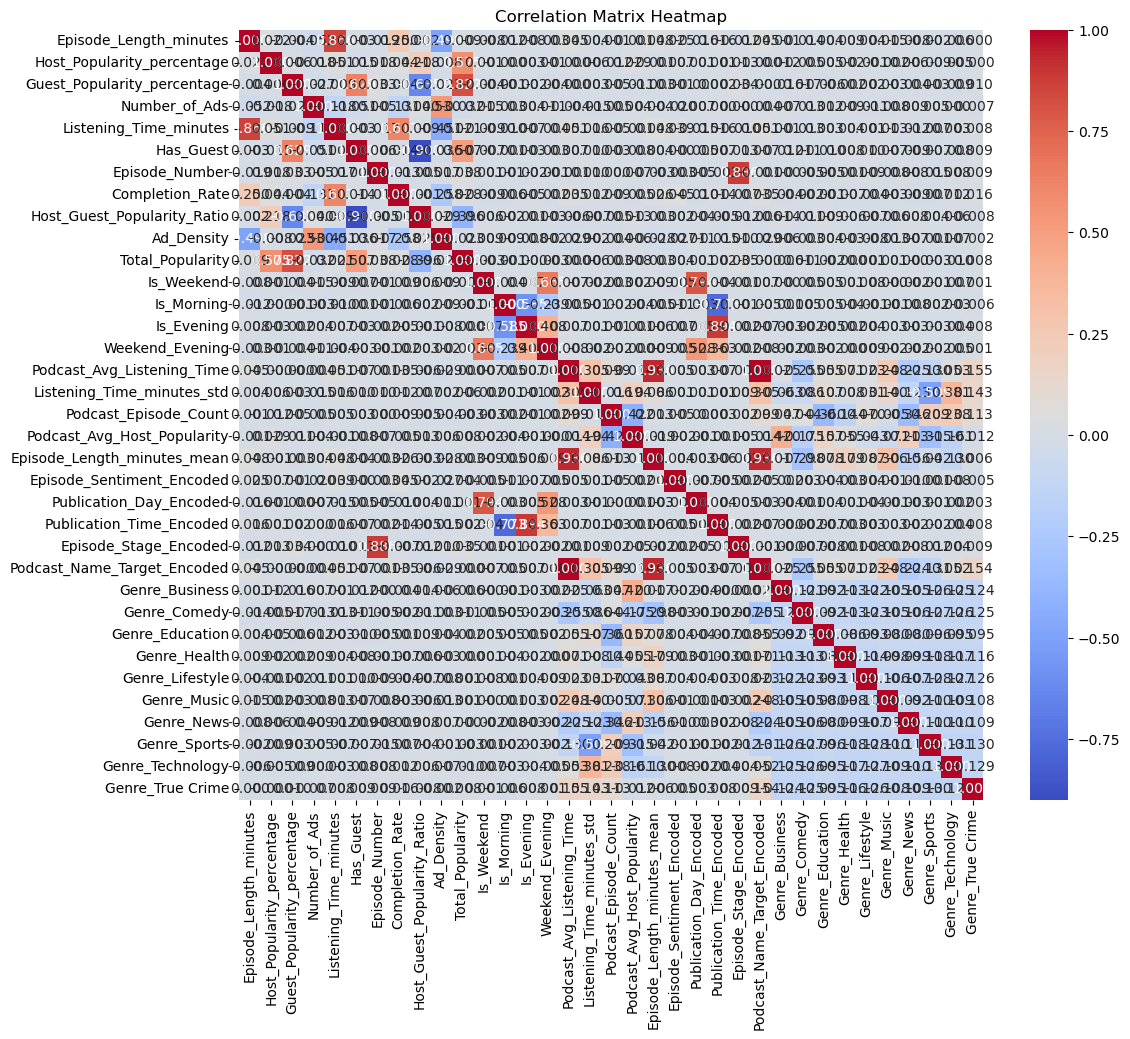

In [32]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Using 24 numerical columns


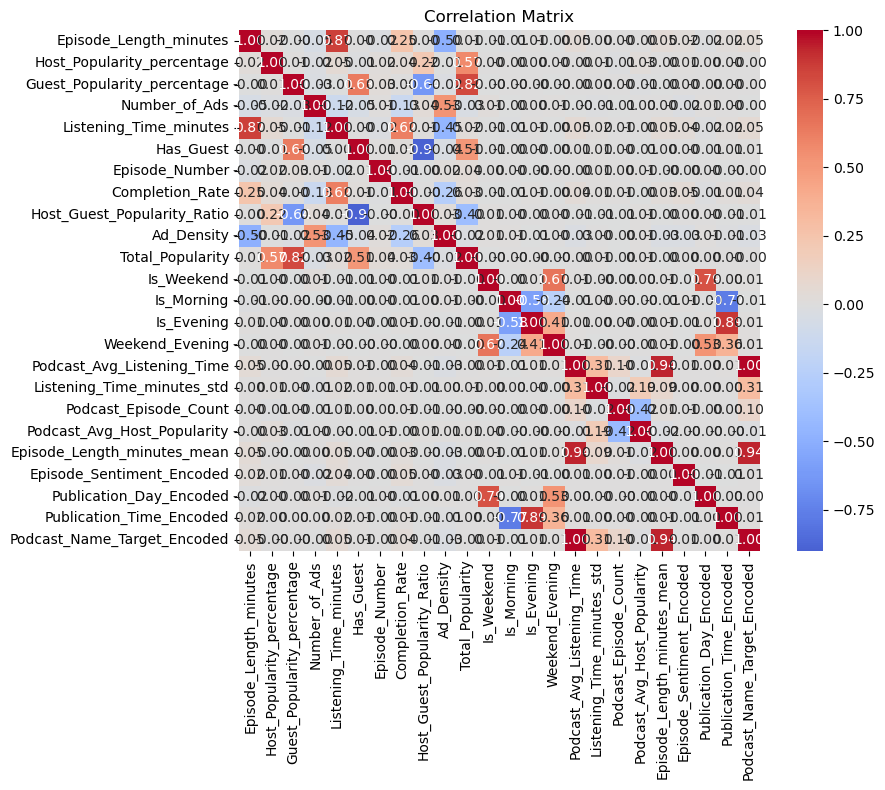


Highly correlated features (|correlation| > 0.9):
  Has_Guest <-> Host_Guest_Popularity_Ratio: -0.900
  Podcast_Avg_Listening_Time <-> Episode_Length_minutes_mean: 0.936
  Podcast_Avg_Listening_Time <-> Podcast_Name_Target_Encoded: 1.000
  Episode_Length_minutes_mean <-> Podcast_Name_Target_Encoded: 0.936

Top 5 features correlated with Listening_Time_minutes:
  Episode_Length_minutes: 0.866
  Completion_Rate: 0.617
  Ad_Density: 0.451
  Number_of_Ads: 0.118
  Podcast_Name_Target_Encoded: 0.051


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Simple correlation analysis and visualization
def simple_correlation(df, target_col='Listening_Time_minutes'):
    
    # Step 1: Get only numerical columns (avoid the string error)
    numerical_df = df.select_dtypes(include=[np.number])
    print(f"Using {len(numerical_df.columns)} numerical columns")
    
    # Step 2: Calculate correlation matrix
    correlation_matrix = numerical_df.corr()
    
    # Step 3: Create simple heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, 
                annot=True,           # Show correlation values
                cmap='coolwarm',      # Color scheme
                center=0,             # Center colormap at 0
                square=True,          # Square cells
                fmt='.2f')            # 2 decimal places
    
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Step 4: Find highly correlated features
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.9:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_value
                ))
    
    # Step 5: Print results
    print("\nHighly correlated features (|correlation| > 0.9):")
    if high_corr_pairs:
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  {feat1} <-> {feat2}: {corr:.3f}")
    else:
        print("  None found!")
    
    # Step 6: Show target correlations if target exists
    if target_col in correlation_matrix.columns:
        target_corr = correlation_matrix[target_col].drop(target_col)
        target_corr = target_corr.abs().sort_values(ascending=False)
        
        print(f"\nTop 5 features correlated with {target_col}:")
        for feat, corr in target_corr.head(5).items():
            print(f"  {feat}: {corr:.3f}")
    
    return correlation_matrix

# Usage:
correlation_matrix = simple_correlation(df_final)

## 🔍 **Analysis of Your Results:**

### **🚨 Highly Correlated Features (Need Action):**

**1. `Podcast_Avg_Listening_Time` <-> `Podcast_Name_Target_Encoded`: 1.000**
- **Perfect correlation!** These are essentially the same feature
- **Action:** Remove one of them (keep `Podcast_Name_Target_Encoded`)

**2. `Podcast_Avg_Listening_Time` <-> `Episode_Length_minutes_mean`: 0.936**
- **Very high correlation** - they measure similar podcast characteristics
- **Action:** Remove `Episode_Length_minutes_mean`

**3. `Episode_Length_minutes_mean` <-> `Podcast_Name_Target_Encoded`: 0.936**
- **Same issue** - redundant information
- **Action:** Already handled by removing `Episode_Length_minutes_mean`

**4. `Has_Guest` <-> `Host_Guest_Popularity_Ratio`: -0.900**
- **Makes sense!** When there's no guest, ratio becomes very high/low
- **Action:** Remove `Host_Guest_Popularity_Ratio` (keep the simpler `Has_Guest`)

### **🎯 Target Correlations (Good Insights):**

**1. `Episode_Length_minutes`: 0.866** 🏆
- **Strongest predictor!** Longer episodes = more listening time
- **Keep this feature** - it's very valuable

**2. `Completion_Rate`: 0.617** 🥈
- **Good predictor** - shows engagement level
- **Keep this feature**

**3. `Ad_Density`: 0.451** 🥉
- **Moderate correlation** - more ads per minute = more listening
- **Keep this feature**

**4. Lower correlations:** Number_of_Ads (0.118), Podcast_Name_Target_Encoded (0.051)
- **Weak predictors** but might still be useful

In [34]:
features_to_remove = [
    'Podcast_Avg_Listening_Time',        # Perfect correlation with target encoding
    'Episode_Length_minutes_mean',       # High correlation with target encoding  
    'Host_Guest_Popularity_Ratio'        # High correlation with Has_Guest
]

df_cleaned = df_final.drop(columns=features_to_remove)
print(f"Removed {len(features_to_remove)} redundant features")
print(f"Shape: {df_final.shape} -> {df_cleaned.shape}")

Removed 3 redundant features
Shape: (750000, 35) -> (750000, 32)


In [35]:
# Convert category column to integer codes
df_final['Episode_Stage_Encoded'] = df_final['Episode_Stage_Encoded'].cat.codes.astype('int32')
# Drop all rows with any null/missing values in df_final
df_final = df_final.dropna()
print(f"New shape after dropping missing rows: {df_final.shape}")

New shape after dropping missing rows: (749998, 35)


df_final.drop(columns=features_to_remove, inplace=True)
print(f"Removed {len(features_to_remove)} redundant features.")
print(f"DataFrame shape is now {df_final.shape}.")

In [36]:
%load_ext cuml.accel

The cuml.accel extension is already loaded. To reload it, use:
  %reload_ext cuml.accel


In [37]:
df_final.dtypes

Episode_Length_minutes         float64
Host_Popularity_percentage     float64
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Listening_Time_minutes         float64
Has_Guest                        int64
Episode_Number                 float64
Completion_Rate                float64
Host_Guest_Popularity_Ratio    float64
Ad_Density                     float64
Total_Popularity               float64
Is_Weekend                       int64
Is_Morning                       int64
Is_Evening                       int64
Weekend_Evening                  int64
Podcast_Avg_Listening_Time     float64
Listening_Time_minutes_std     float64
Podcast_Episode_Count          float64
Podcast_Avg_Host_Popularity    float64
Episode_Length_minutes_mean    float64
Episode_Sentiment_Encoded        int64
Publication_Day_Encoded          int64
Publication_Time_Encoded         int64
Episode_Stage_Encoded            int32
Podcast_Name_Target_Encoded    float64
Genre_Business           

---
**6.3 Use Model-Based Feature Importance**

* Train a model like Random Forest on your dataset.
* Extract feature importance scores from the model.
* Focus on top important features for further modeling.
----

In [38]:
# Simple Random Forest Training with Hyperparameter Tuning
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

print("🚀 Training Random Forest with Hyperparameter Tuning...")

# Prepare data
feature_cols = [col for col in df_final.columns if col != 'Listening_Time_minutes']
X = df_final[feature_cols]
y = df_final['Listening_Time_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train):,}, Features: {len(feature_cols)}")

# Base Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

# Predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)



🚀 Training Random Forest with Hyperparameter Tuning...
Training samples: 599,998, Features: 34


In [39]:
# Print the results
print("Random Forest Results:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Random Forest Results:
Training RMSE: 12.2940
Test RMSE: 13.1170
Training R²: 0.7948
Test R²: 0.7661


In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 0.8, 1.0],
    'bootstrap': [True, False]
}

print("🔍 Starting hyperparameter tuning...")

# Calculate total combinations
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)
print(f"Testing {total_combinations} combinations")

# Initialize model (cuML)
rf = RandomForestRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=1  # Use 1 for cuML
)

#Fit (assuming X_train, y_train are your data)
grid_search.fit(X_train, y_train)

#After fitting, get results:
print("\n✅ Best parameters:")
print(grid_search.best_params_)
print(f"\n📊 Best CV score: {-grid_search.best_score_:.4f}")


🔍 Starting hyperparameter tuning...
Testing 54 combinations
Unused keyword parameter: ccp_alpha during cuML estimator initialization
Unused keyword parameter: monotonic_cst during cuML estimator initialization
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Unused keyword parameter: ccp_alpha during cuML estimator initialization
Unused keyword parameter: monotonic_cst during cuML estimator initialization


/home/patel/anaconda3/envs/rapids-25.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:320: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)
/home/patel/anaconda3/envs/rapids-25.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:320: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)
/home/patel/anaconda3/envs/rapids-25.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:320: UserWarning: The split criterion chosen was not present in the list of options accepted by the model and so the CRITERION_END option has been chosen.
  return init_func(self, *args, **kwargs)
/home/patel/anaconda3/envs/rapids-25.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:3

In [ ]:
rmse_increase = ((test_rmse - train_rmse) / train_rmse) * 100
r2_decrease = ((train_r2 - test_r2) / train_r2) * 100
    
    # Print results
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"RMSE increase: {rmse_increase:.2f}%")
print(f"R² decrease: {r2_decrease:.2f}%")
    
    # Check overfitting
if rmse_increase < 10 and r2_decrease < 5:
    print("✅ NO OVERFITTING - Good generalization!")
elif rmse_increase < 20 and r2_decrease < 10:
    print("⚠️ MILD OVERFITTING - Monitor closely")
else:
    print("❌ OVERFITTING DETECTED - Needs attention")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Your predictions (assuming you already have these)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted - Training
ax1.scatter(y_train, y_pred_train, alpha=0.6, color='blue')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Set: Actual vs Predicted\nR² = {train_r2:.4f}, RMSE = {train_rmse:.4f}')
ax1.grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted - Test
ax2.scatter(y_test, y_pred_test, alpha=0.6, color='red')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Test Set: Actual vs Predicted\nR² = {test_r2:.4f}, RMSE = {test_rmse:.4f}')
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals - Training
train_residuals = y_train - y_pred_train
ax3.scatter(y_pred_train, train_residuals, alpha=0.6, color='blue')
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predicted Values')
ax3.set_ylabel('Residuals')
ax3.set_title('Training Residuals')
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals - Test
test_residuals = y_test - y_pred_test
ax4.scatter(y_pred_test, test_residuals, alpha=0.6, color='red')
ax4.axhline(y=0, color='r', linestyle='--')
ax4.set_xlabel('Predicted Values')
ax4.set_ylabel('Residuals')
ax4.set_title('Test Residuals')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# RMSE comparison
rmse_values = [train_rmse, test_rmse]
rmse_labels = ['Training', 'Test']
colors = ['blue', 'red']

ax1.bar(rmse_labels, rmse_values, color=colors, alpha=0.7)
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE Comparison')
ax1.grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(rmse_values):
    ax1.text(i, v + max(rmse_values)*0.01, f'{v:.3f}', ha='center', va='bottom')

# R² comparison
r2_values = [train_r2, test_r2]
r2_labels = ['Training', 'Test']

ax2.bar(r2_labels, r2_values, color=colors, alpha=0.7)
ax2.set_ylabel('R² Score')
ax2.set_title('R² Score Comparison')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(r2_values):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print overfitting analysis
rmse_increase = ((test_rmse - train_rmse) / train_rmse) * 100
r2_decrease = ((train_r2 - test_r2) / train_r2) * 100

print("🔍 OVERFITTING ANALYSIS:")
print(f"RMSE increase: {rmse_increase:.2f}%")
print(f"R² decrease: {r2_decrease:.2f}%")

if rmse_increase < 10 and r2_decrease < 5:
    print("✅ NO OVERFITTING - Good generalization!")
elif rmse_increase < 20 and r2_decrease < 10:
    print("⚠️ MILD OVERFITTING - Monitor closely")
else:
    print("❌ OVERFITTING DETECTED - Needs attention")

In [ ]:
print(X.isnull().sum())
print(y.isnull().sum())

In [ ]:
# 1. XGBOOST GPU TRAINING
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np


In [ ]:
# RMSE function
from sklearn.model_selection import train_test_split, KFold
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Your original data preparation
X = df_final.drop('Listening_Time_minutes', axis=1)
y = df_final['Listening_Time_minutes']
print(f"Dataset: {len(X):,} samples, {len(X.columns)} features")

# Split data for final testing
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost parameters
xgb_params = {
    'n_estimators': 400,
    'max_depth': 14,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,    
    'tree_method': 'hist', 
    'device': 'cuda',
    'n_jobs': -1
}

# K-Fold setup
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
scores = []
test_preds = np.zeros(len(X_test)) 

# K-Fold Cross Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full, y_train_full)):
    print(f"Training fold {fold + 1}/{n_splits}...")    
    X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]   
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)  
    val_pred = model.predict(X_val)
    score = rmse(y_val, val_pred)
    scores.append(score)
    
    test_preds += model.predict(X_test) / n_splits      
    print(f"Fold {fold + 1} RMSE: {score:.4f}")

# Print K-Fold results
print(f'\nOptimized Cross-validated RMSE score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max RMSE score: {np.max(scores):.3f}')
print(f'Min RMSE score: {np.min(scores):.3f}')

# Calculate test set performance using averaged predictions
test_rmse = rmse(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print(f'\nFinal Test Performance:')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R²: {test_r2:.4f}')

# Train final model on full training data for comparison
print(f'\nTraining final model on full training set...')
final_model = xgb.XGBRegressor(**xgb_params)
final_model.fit(X_train_full, y_train_full)

y_pred_train = final_model.predict(X_train_full)
y_pred_test_final = final_model.predict(X_test)

train_rmse = rmse(y_train_full, y_pred_train)
test_rmse_final = rmse(y_test, y_pred_test_final)
train_r2 = r2_score(y_train_full, y_pred_train)
test_r2_final = r2_score(y_test, y_pred_test_final)

print(f'\nFinal Model Performance:')
print(f'Training RMSE: {train_rmse:.4f}')
print(f'Training R²: {train_r2:.4f}')
print(f'Test RMSE: {test_rmse_final:.4f}')
print(f'Test R²: {test_r2_final:.4f}')

In [ ]:
print("n")

# Check if OpenCL is available
import pyopencl as cl
print("OpenCL platforms:", cl.get_platforms())

In [ ]:
# 1. LIGHTGBM TRAINING (GPU with CPU fallback)
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np

print("🚀 Training LightGBM Model...")

# Prepare data
X = df_final.drop('Listening_Time_minutes', axis=1)
y = df_final['Listening_Time_minutes']

print(f"Dataset: {len(X):,} samples, {len(X.columns)} features")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMRegressor(
        n_estimators=200,
        random_state=42,
        max_depth=8,
        num_leaves=31,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        metric='rmse',
        verbose=-1
    )
lgb_model.fit(X_train, y_train)
print("✅ GPU training successful!")

# Evaluate model
y_pred_train = lgb_model.predict(X_train)
y_pred_test = lgb_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\n📊 MODEL PERFORMANCE:")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

overfitting = (train_r2 - test_r2) / train_r2 * 100
print(f"Overfitting: {overfitting:.2f}%")

print("✅ LightGBM training completed!")

In [ ]:
# Option 4: Optimized CPU version with maximum parallelization (fallback)
print("\nFallback: Optimized CPU version with maximum cores...")
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Prepare data
X = df_final.drop('Listening_Time_minutes', axis=1)
y = df_final['Listening_Time_minutes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optimized CPU Random Forest
rf_cpu = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,  # Use all available CPU cores
    max_depth=16,  # Prevent overfitting and reduce memory
    max_features='sqrt',  # Reduce computation
    bootstrap=True,
    oob_score=True  # Out-of-bag score for validation
)

rf_cpu.fit(X_train, y_train)

# Get feature importance
feature_importance_cpu = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_cpu.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 most important features (Optimized CPU):")
print(feature_importance_cpu.head(10))

# Performance comparison function
def compare_predictions(models_dict, X_test, y_test):
    """Compare predictions from different models"""
    from sklearn.metrics import mean_squared_error, r2_score
    
    print("\n=== Model Performance Comparison ===")
    for name, model in models_dict.items():
        try:
            if hasattr(model, 'predict'):
                y_pred = model.predict(X_test)
                # Convert cuDF to pandas if needed
                if hasattr(y_pred, 'to_pandas'):
                    y_pred = y_pred.to_pandas()
                if hasattr(y_test, 'to_pandas'):
                    y_test_np = y_test.to_pandas()
                else:
                    y_test_np = y_test
                    
                mse = mean_squared_error(y_test_np, y_pred)
                r2 = r2_score(y_test_np, y_pred)
                print(f"{name}: MSE={mse:.4f}, R²={r2:.4f}")
        except Exception as e:
            print(f"{name}: Error - {e}")

# Usage example:
# models = {'GPU_RF': rf_gpu, 'XGB_GPU': xgb_gpu, 'LGB_GPU': lgb_gpu, 'CPU_RF': rf_cpu}
# compare_predictions(models, X_test, y_test)

---

This step is iterative: you might go back and engineer or remove features based on findings.

---

# Dimensionalitty Reduciton

In [ ]:
# Step 1: Diagnose NaN issues
print("=== Diagnosing NaN Issues ===")
print(f"Dataset shape: {X.shape}")
print(f"Total NaN values: {X.isnull().sum().sum()}")
print(f"Columns with NaN values:")
nan_columns = X.isnull().sum()
print(nan_columns[nan_columns > 0])

# Check NaN percentage per column
nan_percentage = (X.isnull().sum() / len(X)) * 100
print(f"\nNaN percentage per column:")
print(nan_percentage[nan_percentage > 0])

In [ ]:
# Option 1: Drop rows with NaN (Recommended - minimal data loss)
print("\n=== Option 1: Drop rows with NaN (Recommended) ===")
X = X.dropna()
print(f"Cleaned dataset shape: {X.shape}")
print(f"Rows lost: {len(X) - len(X)} ({((len(X) - len(X))/len(X)*100):.6f}%)")


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

In [ ]:
def feature_engineering_pipeline(df):
    """Complete feature engineering pipeline"""
    
    # 1. Handle missing values
    df['Episode_Length_minutes'] = df.groupby('Genre')['Episode_Length_minutes'].transform(
        lambda x: x.fillna(x.median())
    )
    df['Has_Guest'] = df['Guest_Popularity_percentage'].notna().astype(int)
    df['Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].fillna(0)
    
    # 2. Create new features
    df['Episode_Number'] = df['Episode_Title'].str.extract('(\d+)').astype(float)
    df['Completion_Rate'] = (df['Listening_Time_minutes'] / df['Episode_Length_minutes']).clip(0, 1)
    df['Ad_Density'] = df['Number_of_Ads'] / df['Episode_Length_minutes']
    df['Is_Weekend'] = df['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)
    df['Total_Popularity'] = df['Host_Popularity_percentage'] + df['Guest_Popularity_percentage']
    
    # 3. Encode categorical variables
    sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    df['Episode_Sentiment_Encoded'] = df['Episode_Sentiment'].map(sentiment_mapping)
    
    # 4. One-hot encode Genre
    genre_dummies = pd.get_dummies(df['Genre'], prefix='Genre')
    df = pd.concat([df, genre_dummies], axis=1)
    
    # 5. Remove unnecessary columns
    df = df.drop(['id', 'Episode_Title', 'Genre', 'Publication_Day', 
                  'Publication_Time', 'Episode_Sentiment', 'Podcast_Name'], axis=1)
    
    return df

# Apply the pipeline
df_engineered = feature_engineering_pipeline(df.copy())
print(f"Original features: {df.shape[1]}")
print(f"Engineered features: {df_engineered.shape[1]}")
print("✅ Feature engineering pipeline complete!")